In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import json
import cv2
import os

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.2 True


C:\Users\Shaheryar\anaconda3\envs\sord_env\lib\site-packages\mmcv\__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


2.26.0
11.3
MSVC 192829924


In [47]:
%config Completer.use_jedi = False

In [48]:
DATASET_BASE_PATH=r'D:\SORD AI\Dataset'

In [49]:
object_id_mapping={}

In [50]:
f = open(DATASET_BASE_PATH+"\config.json")
data = json.load(f)
data_stats=[]

In [51]:
for i in range(17):
    for key, val in data[i]['object_classes'].items():
        data_stats.append({
            'object':key,
            'count':val,
            'type':'single_asset'
        })
        

In [52]:
df=pd.DataFrame(data_stats)

In [53]:
df

,object,count,type
0,bicycle,2500,single_asset
1,cabinet,2500,single_asset
2,cardboard_box,2500,single_asset
3,dolly,2500,single_asset
4,exit_sign,2500,single_asset
5,fire_Extinguisher,2500,single_asset
6,forklift,2500,single_asset
7,jack,2500,single_asset
8,l_klt_8210,2500,single_asset
9,l_klt_4147,2500,single_asset


In [54]:
for i in range(17,len(data)):
    if data[i]['dataset_id']!='SORDI_2022_h4021':
        for key, val in data[i]['object_classes'].items():
            data_stats.append({
                'object':key,
                'count':val,
                'type':data[i]['dataset_name'].split(" ")[0]
            })

In [55]:
df=pd.DataFrame(data_stats)

In [56]:
df['object']=df['object'].str.lower()

In [15]:
img=df.groupby(by='object').sum()

In [57]:
df.groupby(by='object').sum()

,count
object,
bicycle,569596
cabinet,657513
cardboard_box,1729240
dolly,3538933
exit_sign,61855
fire_extinguisher,82167
forklift,317017
jack,399127
l_klt_4147,650755


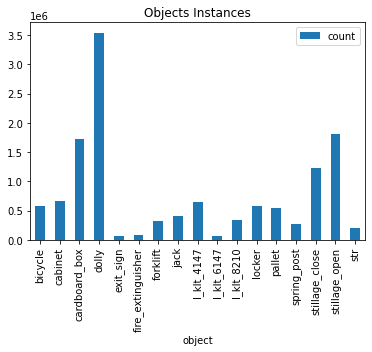

In [59]:
df.groupby(by='type').sum().plot(kind='bar')

In [18]:
df[df['object']=='stillage_open']

,object,count,type
15,stillage_open,2500,single_asset
29,stillage_open,1489,industrial
41,stillage_open,5056,industrial
55,stillage_open,758889,regensburg
71,stillage_open,1047295,regensburg


In [37]:
images_stats=[]
for i in range(0,len(data)):
    if data[i]['dataset_id']!='SORDI_2022_h4021':
        if i>16:
            t=data[i]['dataset_name'].split(" ")[0]
        else:
            t="single"
        images_stats.append({
            'folder': data[i]['dataset_id'],
            'count': data[i]['dataset_size'],
        
            'type':t
        })

In [38]:
img_df=pd.DataFrame(images_stats)

In [39]:
img_df[0:17].sum()

folder    SORDI_2022_h4001SORDI_2022_h4002SORDI_2022_h40...
count                                                 42500
type      singlesinglesinglesinglesinglesinglesinglesing...
dtype: object

In [43]:
img_df.groupby(by='type').sum()

,count
type,
KLT,8262
Warehouse,8312
industrial,29424
regensburg,105839
single,42500


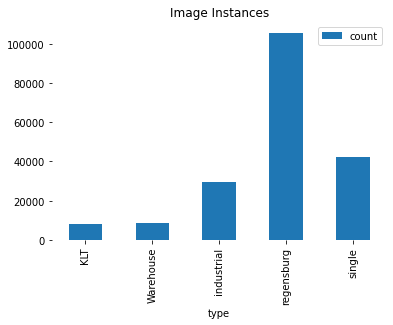

In [42]:
img_df.groupby(by='type').sum().plot(kind='bar')
plt.title('Image Instances')
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)
plt.show()

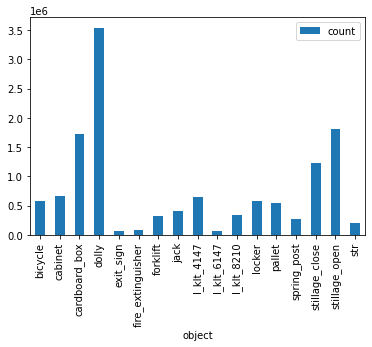

In [61]:
df.groupby(by='object').sum().plot(kind='bar')
plt.show()

In [62]:
df.groupby(by='object').sum()

,count
object,
bicycle,569596
cabinet,657513
cardboard_box,1729240
dolly,3538933
exit_sign,61855
fire_extinguisher,82167
forklift,317017
jack,399127
l_klt_4147,650755


## Visualizing a test image and its labels

In [88]:
all_classes=list(df['object'].unique())

In [89]:
all_classes

['bicycle',
 'cabinet',
 'cardboard_box',
 'dolly',
 'exit_sign',
 'fire_extinguisher',
 'forklift',
 'jack',
 'l_klt_8210',
 'l_klt_4147',
 'l_klt_6147',
 'locker',
 'pallet',
 'spring_post',
 'stillage_close',
 'stillage_open',
 'str']

In [301]:
test_img_path = r'D:\SORD AI\Dataset\SORDI_2022_Regensburg_plant\SORDI_2022_h4025_regensburg plant\images\130.jpg'
test_img_labels = r'D:\SORD AI\Dataset\SORDI_2022_Regensburg_plant\SORDI_2022_h4025_regensburg plant\labels\json\130.json'

In [302]:
f=open(test_img_labels)
annotations = json.load(f)

(720, 1280, 3)


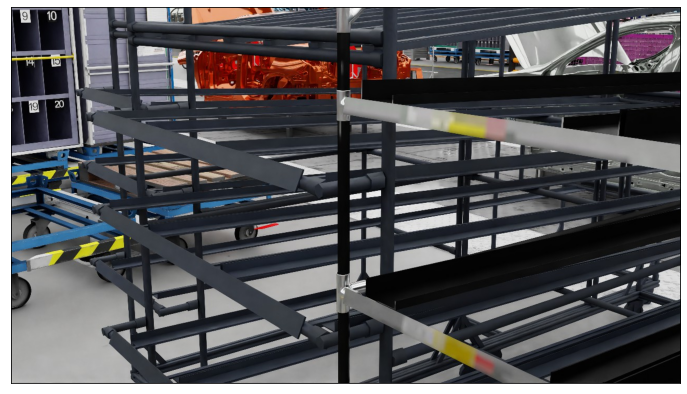

In [303]:
img = cv2.imread(test_img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.rcParams["figure.figsize"] = (12,12)
plt.xticks([])
plt.yticks([])
plt.imshow(img)


In [307]:
img_show=img.copy()
i=0
for annot in annotations:
    x1,y1,x2,y2=annot['Left'],annot['Top'],annot['Right'],annot['Bottom']
    size=((x2-x1)*(y2-y1)/(img.shape[0]*img.shape[1]))
    size = (round(size*100,2))
    cls_name=annot['ObjectClassName']
    if size >=0.2:
        size = str(size)
        print(size,cls_name )
        img_show = cv2.rectangle(img_show, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(img_show,str(size)+ ' '+cls_name , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    i=i+1

6.67 dolly
7.76 dolly
4.12 pallet
1.31 dolly
2.58 dolly
0.2 dolly
0.26 dolly
0.27 dolly
2.68 stillage_open


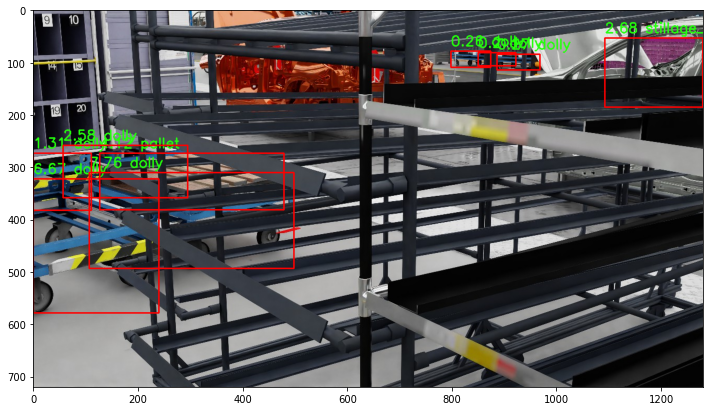

In [308]:
plt.imshow(img_show)